# Classifying Tumors in Mammograms

# Part 1B - MIAS Base CNN Modeling

The [MIAS dataset](http://peipa.essex.ac.uk/info/mias.html) was the initial dataset used to explore classifying images for tumor identification in mammograms. 

## Contents
- [Data Import](#Data-Import-&-Cleaning)
- [Prepare Images for Modeling](#Prepare-images-for-modeling)
- [Modeling](#Modeling)
    - [CNN](#CNN)
    - [Other Examples of CNN Attempts](#Other-Examples-of-CNN-Attempts)
    - [Bayes Search](#Bayes-Search-to-try-and-Optimize-the-CNN)
- [Conclusions](#Conclusions)

## Overview

### Modeling Techniques Explored

- Resizing
- Gray scaling of image
- Reflection - flip images horizontally and vertically
- Rotation - Form of upsampling your dataset since it creates rotated copies of the same image.


### Choice of Hyperparameters
- Loss function - binary_crossentropy
- Optimizer - Adam (Looking for a steady decrease in loss rate)
- Metrics - Since we're dealing with life and death cancer diagnoses, False Negatives are far more detrimental since they mean you miss diiagnosing a tumor so reducing False Negatives is the aim. Also should pay attention to Accuracy and F1 score. Accuracy is important since we care how many True Positives our model finds but the F1 score is the harmonic mean of the model's Precision and Recall and is used when the False Negatives and False Positives might be more critical. In our classification problem, there is definitely imbalanced class distribution and thus F1-score might be a better metric to evaluate our model on.
- Learning Rate / Epochs - Aimed for slower learning rates
- The sigmoid function is used for the two-class logistic regression, whereas the softmax function is used for the multiclass logistic regression. In our case, we used the sigmoid for the tumor/no tumor classification. If we were to expand this project to tumor types we would need to use the softmax function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
import glob
import category_encoders as ce
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras import utils

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

## Data Import

In [4]:
#Files located in ./all-mias.tar/
#images all start with mdb

files = glob.glob('all-mias.tar/mdb*')

'001'

In [5]:
#Read in the files
#image_size sets the image dimensions, base is 1024x1024
image_size = 128
images = []
for file in files:
    image = cv2.imread(file,0)
    image = cv2.resize(image, (image_size, image_size))
    images.append(image)
    

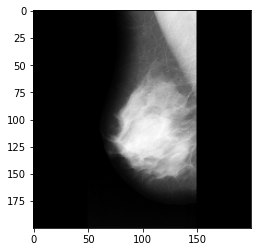

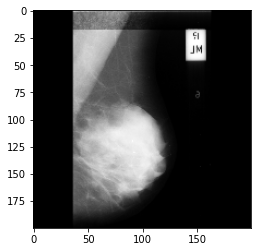

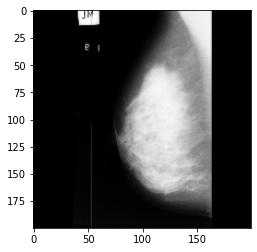

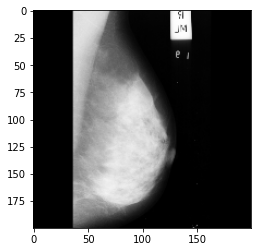

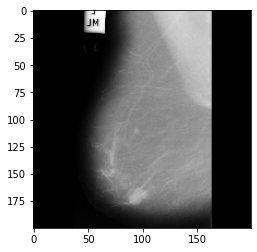

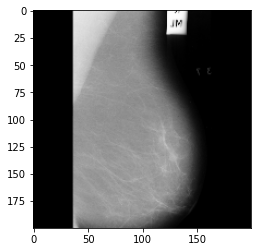

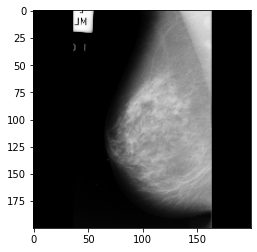

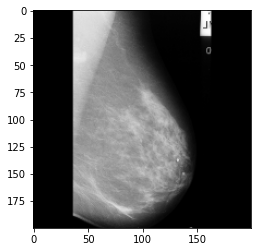

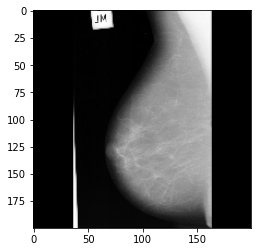

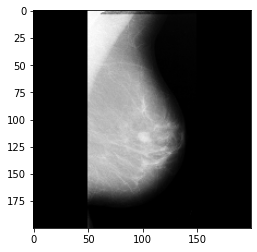

In [6]:
#Display First ten images
for i in range(10):
    plt.imshow(images[i],cmap=plt.get_cmap('gray'))
    plt.show()

## Load in the documentation on tumors

Text file provided with:
MIAS database reference number.

 - Character of background tissue:

        F  Fatty
        G  Fatty-glandular
        D  Dense-glandular
     

 - Class of abnormality present:

          CALC  Calcification
          CIRC  Well-defined/circumscribed masses
          SPIC  Spiculated masses
          MISC  Other, ill-defined masses
          ARCH  Architectural distortion
          ASYM  Asymmetry
          NORM  Normal

 - Severity of abnormality;

          B  Benign
          M  Malignant
      
 - x,y image-coordinates of centre of abnormality.

 - Approximate radius (in pixels) of a circle enclosing the abnormality. 

In [9]:
#Read in CSV, cleaned separately of extraneous information
labels = pd.read_csv('all-mias.tar/Info_red.txt',delimiter=' ',names=['ID','bg','ab_type','diagnosis','ab_x','ab_y','ab_r'])

In [10]:
#If no tumor, make an N
#Add tumor column
labels['diagnosis'].fillna('N',inplace=True)
labels['tumor'] = labels['diagnosis'].map(lambda x: 0 if x == 'N' else 1)
labels['tumor'].value_counts(normalize=True)

0    0.627273
1    0.372727
Name: tumor, dtype: float64

In [11]:
#Make mask layout
labels['ab_x'].fillna(0,inplace=True)
labels['ab_y'].fillna(0,inplace=True)
labels['ab_r'].fillna(0,inplace=True)

In [12]:
#Check for the biggest and smallest box
labels[labels['ab_r'] > 0]['ab_r'].max(),labels[labels['ab_r'] > 0]['ab_r'].max()

197.0

In [13]:
#Check that all empty things are filled
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         330 non-null    object 
 1   bg         330 non-null    object 
 2   ab_type    330 non-null    object 
 3   diagnosis  330 non-null    object 
 4   ab_x       330 non-null    float64
 5   ab_y       330 non-null    float64
 6   ab_r       330 non-null    float64
 7   tumor      330 non-null    int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 20.8+ KB


In [14]:
#330 entries, 322 images, some duplications
labels['ID'] = labels['ID'].map(lambda x: x[3:])
labels['ID'].value_counts()

226    3
223    2
239    2
005    2
144    2
      ..
107    1
106    1
105    1
104    1
322    1
Name: ID, Length: 322, dtype: int64

In [15]:
#Check breakdown of tumor diagnosis
labels['diagnosis'].value_counts(normalize=True)

N    0.627273
B    0.209091
M    0.163636
Name: diagnosis, dtype: float64

## Prepare images for modeling

 - Scale the images
 - Setup X and y
    - Classify y two ways, either tumor or not, or type of tumor
    - Loss function, final activation, and output layer size modified

In [16]:
images = [image/255 for image in images]

In [17]:
images = np.array(images)

Comment out one of the next two blocks, first block does classification on tumor type, next does it just on whether or not there is a tumor

In [19]:
# X = np.expand_dims(images,axis=3)
# y = labels.drop_duplicates(subset='ID')[['ab_type']]
# encoder = ce.OneHotEncoder(cols=['ab_type'], use_cat_names=True,
#                         return_df=False)
# print(y['ab_type'].nunique())
# y = encoder.fit_transform(y)
# loss_func, act_func, out_layer = 'categorical_crossentropy', 'softmax', 7


In [20]:
X = np.expand_dims(images,axis=3)
y = labels.drop_duplicates(subset='ID')['tumor']
loss_func, act_func, out_layer = 'binary_crossentropy', 'sigmoid', 1

y.shape

(322,)

Train test split

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

In [22]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((241, 200, 200, 1), (241,), (81, 200, 200, 1), (81,))

## Modeling

Various sets of CNN fits were tried, with the following:
 - Number and size of hidden Convolution layers (1 to 4 layers, 10-128 filters)
 - Number and size Dense Layers (1-5 dense layers, 120-2000 nodes)
 - Various forms of regularization (L1,Batch, and Dropout)
 - Image size (100-1024 pixels)
 - Rotations


## CNN

In [46]:
#Instantiate model
cnn = Sequential()

#convolution layers
cnn.add(Conv2D(filters = 20,       #number of filters to use
              kernel_size = (4,4),   #dimensions of the filters
              activation = 'relu',    #activation function
              input_shape = (image_size, image_size,1)))  #shape of image
cnn.add(MaxPooling2D(pool_size = (2,2))) 
cnn.add(Conv2D(20, kernel_size = (4,4), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())

#dense layers
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(48, activation = 'relu'))

# Example lines of the regularization methods tried
# cnn.add(Dropout(0.2))
# cnn.add(BatchNormalization())
# ,kernel_regularizer=l2(0.01)
# cnn.add(Dropout(0.3))

#finalize things
cnn.add(Dense(out_layer, activation = act_func))
cnn.compile(loss = loss_func,
           optimizer = 'adam',
           metrics = ['accuracy'])

In [47]:
# Early stop to end model, patience varied as needed when changin models
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [48]:
#Perform the fit, epochs set to 1000 since early stop being used. 
tf.random.set_seed(42)
history_bw = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 16,
                 epochs = 1000,
                 verbose = 1,
                 callbacks = [early_stop]
)

Epoch 00011: early stopping


In [49]:
#Make predictions, round since output is in probability
preds = cnn.predict(X_test).round(0)
#Base score
metrics.f1_score(y_test,preds),metrics.accuracy_score(y_test,preds)

(0.4545454545454545, 0.7037037037037037)

In [51]:
#Confusion matrix
cm = confusion_matrix(y_test, preds)

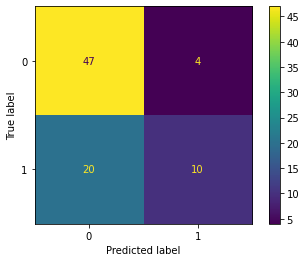

In [54]:
#plot CM
ConfusionMatrixDisplay(cm).plot()

In [52]:
#Function for plotting CNN history
def Loss_Acc_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,8))
    fig.suptitle("Model Performance", fontsize = 25, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')

    ax1.plot(range(1, len(acc) + 1), acc,  color='#185fad')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, color='orange')
    ax1.set_title('History of Accuracy by Epoch', fontsize=20)
    ax1.set_xlabel('Epoch', fontsize=18)
    ax1.set_ylabel('Accuracy', fontsize=18)
    ax1.legend(['training', 'validation'], fontsize=18)


    ax2.plot(range(1, len(loss) + 1), loss, color='#185fad')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, color='orange')
    ax2.set_title('History of Loss by Epoch', fontsize=20)
    ax2.set_xlabel('Epoch', fontsize=18)
    ax2.set_ylabel('Binary Crossentropy (Loss)', fontsize=18)
    ax2.legend(['training', 'validation'], fontsize=18)
    
    plt.tight_layout()
    plt.show()
    

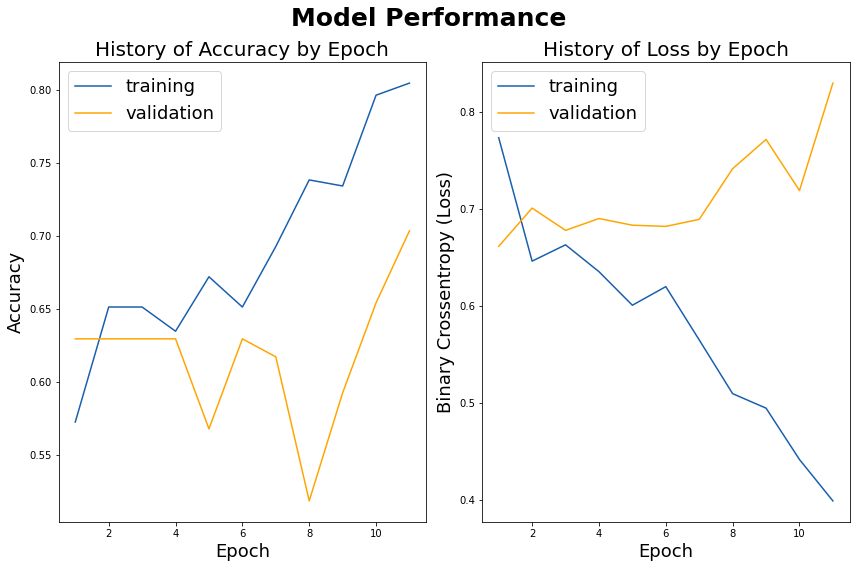

In [53]:
#run the plot for the history
Loss_Acc_Plot(history_bw.history['accuracy'],history_bw.history['val_accuracy'],
               history_bw.history['loss'],history_bw.history['val_loss'])

## Other Examples of CNN Attempts

The following shows some of the other example nets tried, rows were deactivated or modified to try different things. 

In [50]:
# tf.random.set_seed(42)
# cnn = Sequential()
# pool_size = 2
# cnn.add(Conv2D(filters = 32,       #number of filters to use
#               kernel_size = (4,4),   #dimensions of the filters
#               activation = 'relu',    #activation function
#               input_shape = (image_size,image_size,1), #shape of image
#               padding='valid', 
#               #strides=(pool_size,pool_size)
#               ))  
# cnn.add(MaxPooling2D(pool_size = (pool_size,pool_size))) 
# cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size = (pool_size,pool_size)))
# # cnn.add(Conv2D(20, kernel_size = (4,4), activation = 'relu'))
# # cnn.add(MaxPooling2D(pool_size = (pool_size,pool_size)))
# cnn.add(Flatten())
# # cnn.add(Dense(32, activation = 'relu'))
# # cnn.add(Dense(32, activation = 'relu'))
# # cnn.add(Dense(32, activation = 'relu'))
# # cnn.add(Dense(32, activation = 'relu'))
# # cnn.add(Dense(32, activation = 'relu'))
# cnn.add(Dropout(0))
# cnn.add(Dense(1024, activation = 'relu'))
# cnn.add(Dropout(0.2))
# # cnn.add(Dense(32, activation = 'relu'))

# cnn.summary()
# cnn.add(Dense(out_layer, activation = act_func))
# cnn.compile(loss = loss_func,
#            optimizer = 'adam',
#            metrics = ['accuracy'])
# # history_bw = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
# #                  batch_size = 32,
# #                  epochs = 1000,
# #                  verbose = 1,
# #                  callbacks = [early_stop]
# # )

In [25]:
# cnn = Sequential()
# cnn.add(Conv2D(filters = 20,       #number of filters to use
#               kernel_size = (4,4),   #dimensions of the filters
#               activation = 'relu',    #activation function
#               input_shape = (image_size,image_size,1)))  #shape of image
# cnn.add(MaxPooling2D(pool_size = (2, 2))) 
# cnn.add(Conv2D(20, kernel_size = (4,4), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))
# cnn.add(Flatten())
# cnn.add(Dense(2048, activation = 'relu'))
# #cnn.add(Dense(512, activation = 'relu'))
# #cnn.add(Dense(32, activation = 'relu'))
# cnn.add(Dense(1, activation = 'sigmoid'))
# cnn.compile(loss = 'binary_crossentropy',
#            optimizer = 'adam',
#            metrics = ['accuracy'])

In [24]:
# cnn = Sequential()

# cnn.add(Conv2D(32, (3,3), padding='valid', strides=(1, 1),input_shape = (image_size,image_size,1), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size=(3, 3)))

# cnn.add(Conv2D(64, (3,3), padding='same', strides=(1, 1), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size=(3, 3),strides=2))
# # cnn.add(Dropout(0.2))

# # cnn.add(Conv2D(64, (5,5), padding='same', strides=(1, 1), activation = 'relu'))
# # cnn.add(MaxPooling2D(pool_size=(3, 3),strides=2))

# # cnn.add(Conv2D(32, (5,5), padding='same', strides=(1, 1), activation = 'relu'))
# # cnn.add(MaxPooling2D(pool_size=(2, 2),strides=2))

# # cnn.add(Dropout(0.2))
# cnn.add(Flatten())
# cnn.add(Dense(128, activation = 'relu'))
# cnn.add(Dense(64, activation = 'relu'))
# cnn.add(Dense(out_layer, activation = act_func))
# cnn.compile(loss = loss_func,
#            optimizer = 'adam',
#            metrics = ['accuracy'])

In [ ]:
# cnn = Sequential()

# cnn.add(Conv2D(filters = 32,       #number of filters to use
#               kernel_size = (3, 3),   #dimensions of the filters
#               activation = 'relu',    #activation function
#               input_shape = (128,128,1), #shape of image
#               #padding='valid', 
#               #strides=(1, 1)
#               ))  
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# #cnn.add(Dropout(0.25))
# cnn.add(Flatten())
# cnn.add(Dense(96, activation = 'relu'))
# cnn.add(Dense(1, activation = 'sigmoid'))
# cnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# early_stop = EarlyStopping(monitor = 'val_loss', 
#                            min_delta = 0,
#                            patience = 5, 
#                            verbose = 1, 
#                            mode='auto', 
#                            restore_best_weights=True)
# # Fit model on training data
# history_bw = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
#                  batch_size = 64,
#                  epochs = 100,
#                  verbose = 1,
#                  callbacks=[early_stop]
# )

In [ ]:
# cnn = Sequential()

# cnn.add(Conv2D(filters = 64,       #number of filters to use
#               kernel_size = (3, 3),   #dimensions of the filters
#               activation = 'relu',    #activation function
#               input_shape = (128,128,1), #shape of image
#               #padding='valid', 
#               #strides=(1, 1)
#               ))  
# cnn.add(MaxPooling2D(pool_size=(2, 2)))

# cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# cnn.add(Dropout(0.25))
# cnn.add(Flatten())
# cnn.add(Dense(96, activation = 'relu'))
# cnn.add(Dense(64, activation = 'relu'))
# cnn.add(Dense(64, activation = 'relu'))
# cnn.add(Dense(1, activation = 'sigmoid'))
# cnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# early_stop = EarlyStopping(monitor = 'val_loss', 
#                            min_delta = 0,
#                            patience = 5, 
#                            verbose = 1, 
#                            mode='auto', 
#                            restore_best_weights=True)
# # Fit model on training data
# history_bw = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
#                  batch_size = 64,
#                  epochs = 100,
#                  verbose = 1,
#                  callbacks=[early_stop]
# )

## Bayes Search to try and Optimize the CNN

Attempted a Bayes search with several levels of varying many of the parameters. The results did not turn out well

In [36]:
#function to create a model for the Bayes search

# def model_func(first_fil, sec_fil, kernel_1,kernel_2,pool_1,pool_2,layer_1,layer_2,layer_3,dropout):
#     cnn = Sequential()
#     cnn.add(Conv2D(filters = first_fil,       #number of filters to use
#                   kernel_size = (kernel_1,kernel_1),   #dimensions of the filters
#                   activation = 'relu',    #activation function
#                   input_shape = (image_size, image_size,1)))  #shape of image
#     cnn.add(MaxPooling2D(pool_size = (pool_1, pool_1))) 
#     cnn.add(Conv2D(sec_fil, kernel_size = (kernel_2, kernel_2), activation = 'relu'))
#     cnn.add(MaxPooling2D(pool_size = (pool_2, pool_2)))
#     cnn.add(Flatten())
#     cnn.add(Dense(layer_1, activation = 'relu'))
#     cnn.add(Dropout(dropout))
#     cnn.add(Dense(layer_2, activation = 'relu'))
#     cnn.add(Dropout(dropout))
#     cnn.add(Dense(layer_3, activation = 'relu'))
#     cnn.add(Dropout(dropout))
#     cnn.add(Dense(1, activation = 'sigmoid'))
#     cnn.compile(loss = 'binary_crossentropy',
#                optimizer = 'adam',
#                metrics = ['accuracy'])
#     return cnn

In [57]:
#Create classifier pipeline
# nn = KerasClassifier(build_fn = model_func,batch_size = 32, epochs = 12,verbose = 1)

In [38]:
# Bayes Search parameter grid

# params = {'first_fil':Integer(4,64),
#          'sec_fil':Integer(4,64),
#          'kernel_1':Integer(2,10),
#          'kernel_2':Integer(2,10),
#          'pool_1':Integer(2,5),
#          'pool_2':Integer(2,5),
#          'layer_1':Integer(10,64),
#          'layer_2':Integer(10,64),
#          'layer_3':Integer(10,64),
#          'dropout':Real(0.01,0.3)}

In [39]:
#Run the Bayes search

# cnn_bs = BayesSearchCV(estimator = nn,
#                      search_spaces = params,
#                      n_iter = 200,
#                      cv = 3,
#                      verbose = 1,
#                      random_state=42)
# cnn_bs.fit(X_train,y_train)

## Conclusions

- Massively overfit models and performance is not much better than baseline 62.7%
- Need more training data and to explore more image preprocessing and data augmentation methods
- Be sure to Train test split before augmenting any images. When you rotate images it creates copies and if you split these after the fact you will most likely cause data leakage